## ISYA 2025 Machine Learning Lab 2: Image classification with a Convolutional Neural Network
In this lab you will learn how to use code simple Neural Network Models using torch. We will use a convolutional neural network (CNNs) to build a model that classifies galaxy images according to their morphological properties.

### Dataset
We will use a dataset consisting of 21,785 images of galaxies obtained as part of the [SDSS](https://www.sdss.org/) survey, which were compiles as part of the [astroNN](https://astronn.readthedocs.io/en/latest/) project. These are $69\times69$ RGB images of galaxies with different morphological types. They were assigned labels as part of the [GalaxyZoo](https://www.zooniverse.org/projects/zookeeper/galaxy-zoo/) project, which is a citizen science project that asks users all around the world to classify these images.

Let's start by loading the dataset, and specifically create arrays for the images and the labels. The class names are based on whether the galaxy looks like a spiral disk, or if it has more of an spherical shape. Also, it relates to the orientation of the galaxy with respect to the line of sight. For example, a spiral galaxy can be seen either edge-on, face-on, or anything in between. The task of the classifier below is to automatically identify the 10 different classes into which the images have been classified. We start with the basic imports:

In [ ]:
import h5py
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn.functional as F
import matplotlib.pyplot as plt

The next few cells load the data, converts the labels to numbers, and separate the data into training, test, and validation. It also uses DataLoader to load the data in a torch-friendly way.

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
# Load data
with h5py.File('Galaxy10.h5', 'r') as h5_file:
    images = np.array(h5_file['images'], dtype=np.float32) / 255.0  # Normalize
    labels = np.array(h5_file['ans'])

In [ ]:
# Convert labels to one-hot
labels_onehot = np.zeros((labels.size, 10), dtype=np.float32)
labels_onehot[np.arange(labels.size), labels] = 1.0

# Train/val/test split
train_images = images[0:17500]
train_labels = labels_onehot[0:17500]
test_images = images[17500:]
test_labels = labels_onehot[17500:]

In [ ]:
# Convert to tensors
train_tensor = TensorDataset(torch.tensor(train_images), torch.tensor(train_labels))
test_tensor = TensorDataset(torch.tensor(test_images), torch.tensor(test_labels))

# Split train_tensor into train and val
train_size = int(0.8 * len(train_tensor))
val_size = len(train_tensor) - train_size
train_dataset, val_dataset = random_split(train_tensor, [train_size, val_size])

# Loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_tensor, batch_size=64)

Let's check the shape of our image array. We have a total of 21,785 images, each with a total of $69\times 69 = 4761$ pixels in each of the three color filters (R = red, G = green, B = blue), for a total of 14,283 features in each filter. Below we also display a sample of the galaxies that make up the dataset, together with their assigned label.

In [ ]:
print(np.shape(train_images))

torch.Size([17500, 69, 69, 3])


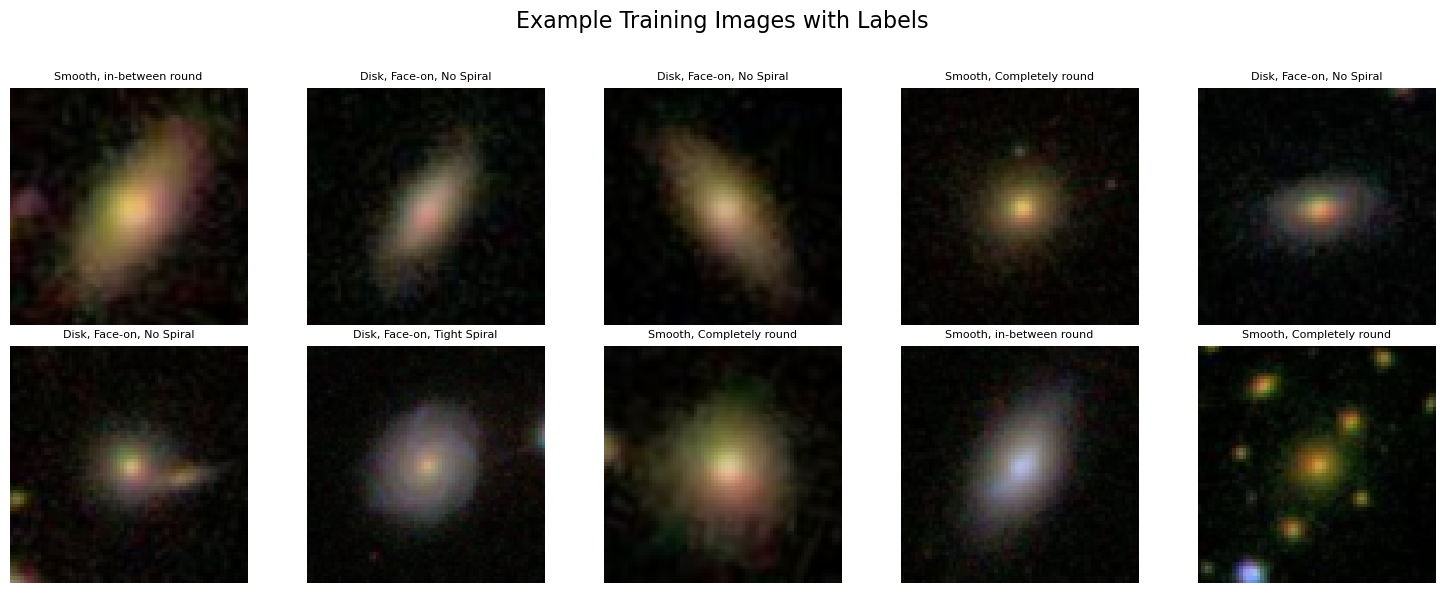

In [ ]:
import matplotlib.pyplot as plt

# Class names
class_names = ['Disk, Face-on, No Spiral', 'Smooth, Completely round', 'Smooth, in-between round',
               'Smooth, Cigar shaped', 'Disk, Edge-on, Rounded Bulge','Disk, Edge-on, Boxy Bulge',
               'Disk, Edge-on, No Bulge', 'Disk, Face-on, Tight Spiral', 'Disk, Face-on, Medium Spiral',
               'Disk, Face-on, Loose Spiral']

# Unpack images and labels from dataset
train_images, train_labels = train_dataset.dataset.tensors  # tensors from original full dataset
train_indices = train_dataset.indices                       # indices used in the training split

# Select 10 examples
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Example Training Images with Labels', fontsize=16)

for i, ax in enumerate(axes.flat):
    idx = train_indices[i]  # original index
    image = train_images[idx].numpy()
    label = train_labels[idx].argmax().item()
    ax.imshow(image)
    ax.set_title(class_names[label], fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()


### Setting up a CNN classifier

We now use torch to create the CNN model that will perform classification. We define a sequential convolutional model that has 3 convolutional layers, with two MaxPooling layers in between. Reall that the MaxPooling layers are used to reduce the number of free parameters in the model, thus reducing the risk of overfitting. The first convolutional layer has 32 neurons or filters, each with a convolutional window of $3\times 3$ pixels. The next two convolutional layers have 64 neurons. After defining the model, we can get the summary with the total number of model parameters.

In [ ]:
# Define model
class GalaxyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 13 * 13, 64)  # for 69x69 input
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

We now compile the model using the *Adam* (Adaptive moment estimation) optimizer, and the categorical cross-entropy loss. The Adam optimizer uses an adaptive learning rate, which means that it jumps shorter steps if the loss function is changing rapidly with respect to the weights, and longer steps when the loss function changes less rapidly. This makes it way more efficient that the regular SGD algorithm.

We will track the accuracy and the validation loss ass the model trains.

In [ ]:
# Instantiate and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GalaxyCNN().to(device)

optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# For plotting
train_losses = []
val_losses = []

The following is the training loop. Note that for each epoch, after we perform the update of the weights, we also evaluate the loss in the validation data. That is what will tell us if the model is over fitting.

In [ ]:
# Training loop
for epoch in range(10):
    model.train()
    running_train_loss = 0.0
    for inputs, targets in train_loader:
        inputs = inputs.permute(0, 3, 1, 2).to(device)  # NHWC to NCHW
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.argmax(dim=1))
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.permute(0, 3, 1, 2).to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets.argmax(dim=1))
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

Epoch 1, Train Loss: 1.4896, Val Loss: 1.2921
Epoch 2, Train Loss: 1.1250, Val Loss: 1.0752
Epoch 3, Train Loss: 1.0020, Val Loss: 1.0279
Epoch 4, Train Loss: 0.9232, Val Loss: 0.9229
Epoch 5, Train Loss: 0.8724, Val Loss: 0.8695
Epoch 6, Train Loss: 0.7880, Val Loss: 0.8422
Epoch 7, Train Loss: 0.7316, Val Loss: 0.8736
Epoch 8, Train Loss: 0.6888, Val Loss: 0.8195
Epoch 9, Train Loss: 0.6457, Val Loss: 0.8073
Epoch 10, Train Loss: 0.6061, Val Loss: 0.7557


Let's plot the training and validation loss. Remember: the training loss can continue to decrease, but the validation loss evaluates the performance in data that the network has NOT seen during training, and so it is the validation loss that we care about when evaluation how the model will perform for new data, which is when the network will really be useful.

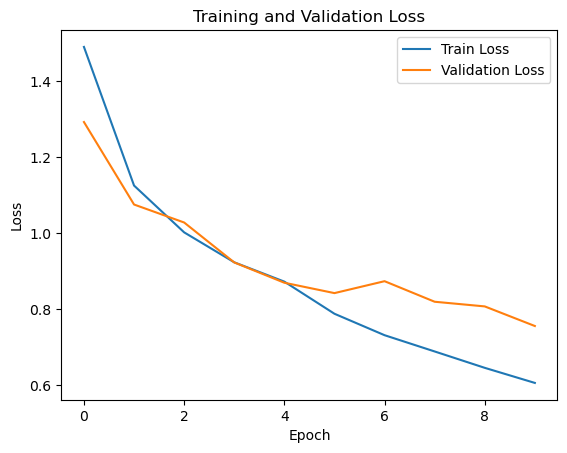

In [ ]:
# Plot losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

Finally, let's test the performace of the model in the test set. In what percentage of new galaxies shown to the network is it correctly classifying them?

In [ ]:
# Test evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.permute(0, 3, 1, 2).to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == targets.argmax(dim=1)).sum().item()
        total += targets.size(0)

print(f"Test Accuracy: {correct / total:.4f}")

Test Accuracy: 0.7456


**Challenge**

Your challenge is to play with the hyper parameter of the neural network to increase the accuracy on the test set above 80\%!